In [1]:
from meta_transformer import transformer
import jax
from jax import random, vmap, grad, jit, value_and_grad
import jax.numpy as jnp
import haiku as hk
from jax import nn
from meta_transformer.mnist import mnist
from meta_transformer import utils
import optax
import numpy as np
import matplotlib.pyplot as plt
import time
from functools import partial
import datasets


rng = random.PRNGKey(42)


def forward(input_chunks, is_training=True):
    t = transformer.Classifier(
        transformer=transformer.Transformer(
            num_heads=5,
            num_layers=6,
            key_size=64,
            dropout_rate=0.1,
        ),
        model_size=128,
        num_classes=10,
    )
    return t(input_chunks, is_training=is_training)


model = hk.transform(forward)


def loss(params, rng, input_chunks, targets, is_training=True):
    logits = model.apply(params, rng, input_chunks, is_training)[:, 0, :]  # [B, C]
    assert logits.shape == targets.shape
    return -jnp.sum(targets * nn.log_softmax(logits, axis=-1), axis=-1).mean()


@jit
def normalize(x):
    return (x - jnp.mean(x)) / jnp.std(x)

/home/lauro/.virtualenvs/meta-models/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Training CIFAR-10

In [2]:
dataset = datasets.load_dataset('cifar10')
dataset = dataset.with_format("jax")

Found cached dataset cifar10 (/home/lauro/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4)
100%|██████████| 2/2 [00:00<00:00, 863.47it/s]


In [3]:
def load_cifar10():
    # Load the CIFAR-10 dataset using Hugging Face Datasets
    dataset = datasets.load_dataset('cifar10')
    dataset = dataset.with_format("jax")

    # Split the dataset into train and test sets
    train_data, train_labels = dataset['train']["img"], dataset['train']["label"]
    test_data, test_labels = dataset['test']["img"], dataset['test']["label"]
    
    # Reshape images to vectors
    train_data = train_data.reshape(-1, 32 * 32 * 3)
    test_data = test_data.reshape(-1, 32 * 32 * 3)
    
    # One-hot encode labels
    train_labels = jnp.eye(10)[dataset['train']['label']]
    test_labels = jnp.eye(10)[dataset['test']['label']]
    
    return (train_data, train_labels), (test_data, test_labels)

(train_data, train_labels), (test_data, test_labels) = load_cifar10()

Found cached dataset cifar10 (/home/lauro/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4)
100%|██████████| 2/2 [00:00<00:00, 955.10it/s]


In [4]:
train_data, test_data = vmap(normalize)(train_data), vmap(normalize)(test_data)

In [5]:
train_data.shape, train_labels.shape, test_data.shape, test_labels.shape

((50000, 3072), (50000, 10), (10000, 3072), (10000, 10))

In [6]:
BATCH_SIZE = 500
SEQ_LEN = 16
CHUNK_SIZE = train_data.shape[-1] // SEQ_LEN


# Chunk and batch data
train_data = train_data.reshape(-1, BATCH_SIZE, SEQ_LEN, CHUNK_SIZE)
train_labels = train_labels.reshape(-1, BATCH_SIZE, 10)
test_data = test_data.reshape(-1, SEQ_LEN, CHUNK_SIZE)
test_labels = test_labels.reshape(-1, 10)

In [17]:
# Optimizer and update function
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-3
opt = optax.adamw(LEARNING_RATE, weight_decay=WEIGHT_DECAY)


@jit
def update_fn(params, opt_state, rng, batch):
    inputs, labels = batch
    l, g = value_and_grad(loss)(params, rng, inputs, labels)
    updates, opt_state = opt.update(g, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, l


@partial(jit, static_argnums=4)
def accuracy(params, rng, inputs, one_hot_targets, is_training=True):
    logits = model.apply(params, rng, inputs, is_training)[:, 0, :]
    predictions = jnp.argmax(logits, axis=-1)
    targets = jnp.argmax(one_hot_targets, axis=-1)
    return jnp.mean(predictions == targets)


@jit
def val_accuracy(params, rng):
    """Compute accuracy on test set."""
    return accuracy(params, rng, test_data, test_labels, is_training=False)

In [18]:
def training_init(rng_key):
    params = model.init(rng_key, train_data[0])
    opt_state = opt.init(params)
    print("Number of parameters:", sum([x.size for x in jax.tree_util.tree_leaves(params)]) / 1e6, "Million")
    return params, opt_state


def train_cifar(params, opt_state, rng_key, epochs = 10):
    info = []
    step = 0
    for epoch in range(epochs):
        print(f"Epoch {epoch}")
        acc = []
        losses = []
        for batch in zip(train_data, train_labels):
            subkey0, subkey1, rng_key = random.split(rng_key, 3)
            train_acc = accuracy(params, subkey0, *batch)
            step += 1
            params, opt_state, l = update_fn(params, opt_state, subkey1, batch)
            acc.append(train_acc) 
            losses.append(l)

        subkey, rng_key = random.split(rng_key)
        info.append(dict(loss=np.mean(losses), epoch=epoch, step=step, train_acc=np.mean(acc), val_acc=val_accuracy(params, subkey)))

    info = utils.dict_concatenate(info)
    return info, model, params


rng_key = random.PRNGKey(42)
subkey, rng_key = random.split(rng_key)
params, opt_state = training_init(subkey)

Number of parameters: 1.81121 Million


In [19]:
subkey, rng_key = random.split(rng_key)
info, model, params = train_cifar(params, opt_state, rng_key, epochs = 50)

Epoch 0


In [ ]:
print("Final training accuracy:", info["train_acc"][-1])
print("Final test accuracy:", info["val_acc"][-1])

Final training accuracy: 0.27014005
Final test accuracy: 0.26459998


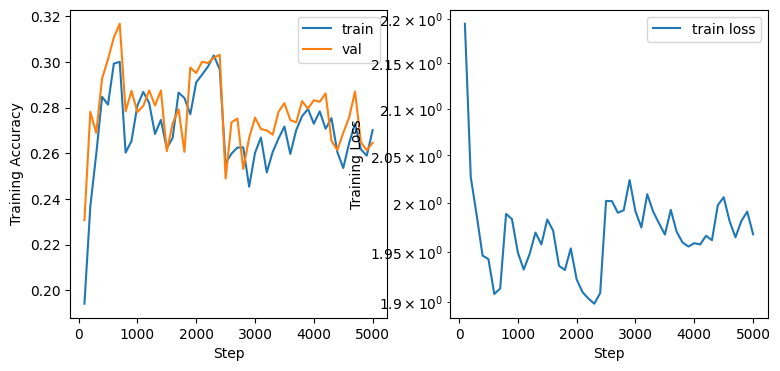

In [ ]:
# Plot
fig, axs = plt.subplots(1, 2, figsize=(9, 4))

# acc
ax = axs[0]
ax.plot(info["step"], info["train_acc"], label="train")
ax.plot(info["step"], info["val_acc"], label="val")
ax.set_ylabel("Training Accuracy")
ax.set_xlabel("Step")
ax.legend()

# loss
ax = axs[1]
ax.plot(info["step"], info["loss"], label="train loss")
ax.set_ylabel("Training Loss")
ax.set_xlabel("Step")
ax.set_yscale("log")
ax.legend()

plt.show()